In [ ]:
!pip install --upgrade datasets
!pip install transformers
!pip install accelerate
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 690.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=08b707cbf5bbea6b89ffcbf95cf33880768ab3996c4aa9134b00dd714c6d7bba
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# Imports

In [ ]:
import numpy as np
import ast
import requests
import pandas as pd
from bs4 import BeautifulSoup
import spacy
from spacy.matcher import Matcher
import csv
import re
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from transformers import TrainerCallback, EarlyStoppingCallback
from torch import cuda
from datasets import Dataset
from datasets import load_metric
import accelerate
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import math
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Hyperparameters

In [ ]:
# Hyperparams
model_name = "bert-base-uncased"
best_model_path = "best_model.pt"
max_length = 256
batch_size = 16
train_val_ratio = 0.9
EPOCHS = 75
LEARNING_RATE = 3e-5
warmup_ratio = 0.0

# Load URLs

In [ ]:
# Load the CSV file containing URLs
csv_file_path = '/content/furniture stores pages.csv'
data = pd.read_csv(csv_file_path)

# Get the first 100 URLs for training
urls_for_training = data['max(page)'][:200].tolist()

# Get the remaining URLs for testing
urls_for_testing = data['max(page)'][200:].tolist()

# Matcher

In [ ]:
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab)

In [ ]:
def on_match(matcher, doc, id, matches):
    print('Matched!', matches)

In [ ]:
product_patterns = [
    [{"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "desk"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shelf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wardrobe"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "ottoman"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "armchair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sideboard"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dresser"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "mirror"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "nightstand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bookcase"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "coffee"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "tv"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sectional"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "loveseat"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "futon"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chaise"}, {"LOWER": "lounge"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "recliner"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "side"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "console"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "vanity"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bar"}, {"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "buffet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hutch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "cuddle"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "pouf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "daybed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "accent"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "ottoman"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shoe"}, {"LOWER": "rack"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "coat"}, {"LOWER": "rack"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bean"}, {"LOWER": "bag"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "rug"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lamp"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "curtain"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "pillow"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "blanket"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "throw"}, {"LOWER": "pillow"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bedding"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "sheet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "mattress"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "frame"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "throw"}, {"LOWER": "blanket"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "duvet"}, {"LOWER": "cover"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "comforter"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "skirt"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dresser"}, {"LOWER": "mirror"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "armoire"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "jewelry"}, {"LOWER": "armoire"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "accent"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bar"}, {"LOWER": "cart"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "room"}, {"LOWER": "divider"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "fireplace"}, {"LOWER": "mantel"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "electric"}, {"LOWER": "fireplace"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "plant"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "light"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "cushion"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hanging"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chest"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "folding"}, {"LOWER": "screen"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "room"}, {"LOWER": "divider"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "storage"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "pouffe"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "coat"}, {"LOWER": "hanger"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shelving"}, {"LOWER": "unit"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wardrobe"}, {"LOWER": "closet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "curtain"}, {"LOWER": "rod"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bedside"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "computer"}, {"LOWER": "desk"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chandelier"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dressing"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bar"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "buffet"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chest"}, {"LOWER": "drawers"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "furniture"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "benches"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "swivel"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bookshelf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sectional"}, {"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bean"}, {"LOWER": "bag"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "armoire"}, {"LOWER": "wardrobe"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "stool"}, {"LOWER": "ottoman"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "media"}, {"LOWER": "console"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "console"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "vanity"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "trunk"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "futon"}, {"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chest"}, {"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "furniture"}, {"LOWER": "cover"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shoe"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hanging"}, {"LOWER": "rack"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "desk"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wall"}, {"LOWER": "shelf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "storage"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wall"}, {"LOWER": "art"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wooden"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "glider"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hammock"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "picnic"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "vanity"}, {"LOWER": "mirror"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "adjustable"}, {"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bunk"}, {"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "crib"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shelving"}, {"LOWER": "system"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "canopy"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "rocking"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sleeper"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "toy"}, {"LOWER": "box"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "writing"}, {"LOWER": "desk"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "curio"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "accent"}, {"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bamboo"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chaise"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hammock"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sun"}, {"LOWER": "lounger"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "umbrella"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "garden"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "deck"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "umbrella"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "folding"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lawn"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "dining"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "sectional"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "garden"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "rocking"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "porch"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lounge"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "adirondack"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "dining"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "chaise"}, {"LOWER": "lounge"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "park"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "porch"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "dining"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "garden"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bistro"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "side"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "umbrella"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hammock"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "dining"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "porch"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lawn"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
]
matcher.add("Products", product_patterns)


# Data extraction

In [ ]:
# Define a function to extract text data from HTML
def extract_text_from_url(url):
    try:
        response = requests.get(url)
        # print(response.content)
        if response.status_code == 200:
            # Process HTML content using spaCy's readability
            doc = nlp(response.text)
            # Extract clean text from the processed document
            clean_text = ' '.join([sent.text for sent in doc.sents])
            return clean_text
    except Exception as e:
        print(f"Error fetching data from {url}: {e}")
    return None

## HTML cleaner 1

In [ ]:
def clean_html(html_text):
    # Create a BeautifulSoup object
    soup = BeautifulSoup(html_text, 'html.parser')

    # Remove scripts, styles, and other specific tags
    for script in soup(["script", "style", "iframe"]):
        script.decompose()

    # Get the text content
    cleaned_text = soup.get_text(separator=" ", strip=True)

    return cleaned_text

## HTML cleaner 2

In [ ]:
def clean_html(html_content):
    # Parse HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract text from the parsed HTML
    text = soup.get_text(separator=' ', strip=True)

    # Clean text: remove special characters, extra spaces, etc.
    cleaned_text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', cleaned_text)  # Remove non-alphanumeric characters

    return cleaned_text

## Web Scraping

In [ ]:
# Initialize lists to store training and testing data
training_texts = []
training_annotations = []

testing_texts = []
testing_annotations = []

# Iterate through each URL in the CSV file and extract text data
for url in urls_for_training:
    text = extract_text_from_url(url)
    if text:
        clean_text = clean_html(text)
        training_texts.append(clean_text)
        text_entities = []
        # print(clean_text)
        doc = nlp(clean_text)
        # print(doc)
        matches = matcher(doc)
        # display(matches)
        for match_id, start, end in matches:
          span = doc[start:end]
          # print(span)
          label = nlp.vocab.strings[match_id]
          text_entities.append((start, end, label))
          # print("Matched entity:", span.text, "| Start:", start, "| End:", end, "| Label:", label)
        training_annotations.append(text_entities)

for url in urls_for_testing:
    text = extract_text_from_url(url)
    if text:
        clean_text = clean_html(text)
        testing_texts.append(clean_text)
        text_entities = []
        doc = nlp(clean_text)
        matches = matcher(doc)
        for match_id, start, end in matches:
          span = doc[start:end]
          # print(span)
          label = nlp.vocab.strings[match_id]
          text_entities.append((start, end, label))
          # print("Matched entity:", span.text, "| Start:", start, "| End:", end, "| Label:", label)
        testing_annotations.append(text_entities)

## Data labeling

In [ ]:
tokenized_train_texts = []
train_labels_list = []

for text, annotations in zip(training_texts, training_annotations):
  tokens = nlp(text)
  labels = ['O'] * len(tokens) # Initialize labels for each token as 'O' (Outside)

  if len(tokens) != 0:
    for start, end, label in annotations:
      for i in range(start, end):
        # print(tokens[i])
        if i == start:
          labels[i] = "B-PROD"
        else:
          labels[i] = "I-PROD"

    tokens = [token.text for token in tokens]
    tokenized_train_texts.append(tokens)
    train_labels_list.append(labels)

# for tokens, labels in zip(tokenized_train_texts, train_labels_list):
#   print("Tokens:", tokens)
#   print("Labels:", labels)
#   print()

In [ ]:
tokenized_test_texts = []
test_labels_list = []

for text, annotations in zip(testing_texts, testing_annotations):
  tokens = nlp(text)
  labels = ['O'] * len(tokens)
  if len(tokens) != 0:
    for start, end, label in annotations:
      for i in range(start, end):
        # print(tokens[i])
        if i == start:
          labels[i] = "B-PROD"
        else:
          labels[i] = "I-PROD"

    tokens = [token.text for token in tokens]
    tokenized_test_texts.append(tokens)
    test_labels_list.append(labels)

# Creating the datasets

In [ ]:
# Create a DataFrame
train_data = {'tokens': tokenized_train_texts, 'ner_tags': train_labels_list}
train_df = pd.DataFrame(train_data)
train_df.to_csv('train_data.csv', index=False)
train_dataset = Dataset.from_pandas(train_df)

test_data = {'tokens': tokenized_test_texts, 'ner_tags': test_labels_list}
test_df = pd.DataFrame(test_data)
test_df.to_csv('test_data.csv', index=False)
test_dataset = Dataset.from_pandas(test_df)

# Reading saved datasets

In [ ]:
def convert_to_list(text):
    try:
        # Use ast.literal_eval to safely evaluate the string representation of the list
        return ast.literal_eval(text)
    except (SyntaxError, ValueError):
        # If unable to convert, return the original text
        return text

# Read the CSV files with the custom converter
train_df = pd.read_csv('train_data.csv', converters={'tokens': convert_to_list, 'ner_tags': convert_to_list})
test_df = pd.read_csv('test_data.csv', converters={'tokens': convert_to_list, 'ner_tags': convert_to_list})

train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)

In [ ]:
label_encoding_dict = {'O': 0, 'B-PROD': 1, 'I-PROD': 2}
label_list = ['O','B-PROD','I-PROD']

# Bert Tokenizer

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [65]:
def tokenize_and_align_labels(tokenizer, examples, max_length=max_length):

    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
        is_split_into_words=True,
        return_special_tokens_mask=True,
        return_length=True,
        return_tensors="pt"  # Return PyTorch tensors
    )

    label_all_tokens = True
    labels = []
    for i, label_list in enumerate(examples["ner_tags"]):
        encoded_labels = []
        previous_word = None
        for word in label_list:
          if word is None:
                encoded_labels.append(-100)
          elif word == '0':
              encoded_labels.append(0)
          elif word != previous_word:
              encoded_labels.append(label_encoding_dict[word])
          else:
              encoded_labels.append(label_encoding_dict[word] if label_all_tokens else -100)
          previous_word = word

          # encoded_labels.extend([label_encoding_dict.get(word, -100)])  # -100 for special tokens

        # Truncate or pad labels to match tokenized input length
        encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
        labels.append(encoded_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def tokenize_dataset(tokenizer, dataset):
    tokenized_dataset = dataset.map(lambda example: tokenize_and_align_labels(tokenizer, example), batched=True)
    return tokenized_dataset

In [66]:
train_tokenized = tokenize_dataset(tokenizer, train_data)
test_tokenized = tokenize_dataset(tokenizer, test_data)

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

In [69]:
from collections import Counter

label_counter = Counter()
for sample in train_tokenized:
    labels = sample["labels"]
    label_counter.update(labels)

print(label_counter)

Counter({0: 19930, -100: 1215, 1: 325, 2: 290})


# Creating training and validation datasets

In [70]:
train_labels = torch.tensor(train_tokenized['labels'])
train_input_ids = torch.tensor(train_tokenized['input_ids'])
train_attention_masks = torch.tensor(train_tokenized['attention_mask'])

In [71]:
# Combine the training inputs into a TensorDataset.
tensor_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Calculate the number of samples to include in each set.
train_size = int(train_val_ratio * len(tensor_dataset))
val_size = len(tensor_dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(tensor_dataset, [train_size, val_size])

print('training samples'.format(train_size))
print('validation samples'.format(val_size))

training samples
validation samples


In [72]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Trainer

In [73]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [74]:
model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))
model.cuda()

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Calculate the total number of training steps
total_steps = len(train_dataloader) * EPOCHS

warmup_steps = int(warmup_ratio * total_steps)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
class NERLossWithClassWeights(nn.Module):
    def __init__(self, class_weights):
        super(NERLossWithClassWeights, self).__init__()
        self.class_weights = class_weights
        self.criterion = nn.CrossEntropyLoss(weight=class_weights.clone().detach())

    def forward(self, predictions, targets):
        # Flatten the predictions and targets to compute the loss
        predictions = predictions.view(-1, predictions.shape[-1])
        targets = targets.view(-1)

        # Compute the loss using cross-entropy loss with class weights
        loss = self.criterion(predictions, targets)
        return loss

unique_labels = [0, 1, 2]  # Class labels

# Flatten the labels
flattened_labels = train_labels.flatten().cpu().numpy()
flattened_labels = [x for x in flattened_labels if x != -100 ]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=unique_labels, y=flattened_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

# Create the loss function instance
class_weight_loss = NERLossWithClassWeights(class_weights)

In [76]:
best_f1 = 0.0

train_loss_per_epoch = []
val_loss_per_epoch = []

precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

for epoch_num in range(EPOCHS):

    # TRAIN

    print('Epoch: ', epoch_num + 1)
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        logit = output.logits
        loss = class_weight_loss(logit,labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    # Validation

    model.eval()
    valid_loss = 0
    valid_pred = []
    valid_true = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(validation_dataloader, desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.extend(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))
            valid_true.extend(labels.cpu().numpy())

    # Flatten the lists to 1D arrays
    valid_pred = np.array(valid_pred).flatten()
    valid_true = np.array(valid_true).flatten()

    # Calculate metrics for this epoch
    precision = precision_score(valid_true, valid_pred, average='weighted', zero_division=0)
    recall = recall_score(valid_true, valid_pred, average='weighted')
    f1 = f1_score(valid_true, valid_pred, average='weighted')
    accuracy = accuracy_score(valid_true, valid_pred)

    # Store metrics for plotting later
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

    val_loss_per_epoch.append(valid_loss / (step_num + 1))

    # Loss and metrics message
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_dataset) / batch_size), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(val_dataset) / batch_size), valid_loss / (step_num_e + 1)))

    print("Precision: {0:.4f}".format(precision))
    print("Recall: {0:.4f}".format(recall))
    print("F1 Score: {0:.4f}".format(f1))
    print("Accuracy: {0:.4f}".format(accuracy))

    if f1 > best_f1:
      best_f1 = f1
      # Save the model checkpoint
      torch.save(model.state_dict(), best_model_path)

Epoch:  1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 1.1053662300109863 
1/1 val loss: 0.9761313199996948 
Precision: 0.7056
Recall: 0.5247
F1 Score: 0.5974
Accuracy: 0.5247
Epoch:  2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 1.0148565769195557 
1/1 val loss: 1.0458014011383057 
Precision: 0.6613
Recall: 0.4870
F1 Score: 0.5545
Accuracy: 0.4870
Epoch:  3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.9467986583709717 
1/1 val loss: 0.9671225547790527 
Precision: 0.6670
Recall: 0.5291
F1 Score: 0.5855
Accuracy: 0.5291
Epoch:  4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.888322937488556 
1/1 val loss: 0.8366703987121582 
Precision: 0.6809
Recall: 0.6055
F1 Score: 0.6379
Accuracy: 0.6055
Epoch:  5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.8112385749816895 
1/1 val loss: 0.9188918471336365 
Precision: 0.6727
Recall: 0.5530
F1 Score: 0.6033
Accuracy: 0.5530
Epoch:  6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.7373095512390136 
1/1 val loss: 0.7388544082641602 
Precision: 0.6851
Recall: 0.6406
F1 Score: 0.6595
Accuracy: 0.6406
Epoch:  7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.6768079996109009 
1/1 val loss: 0.6773349046707153 
Precision: 0.6849
Recall: 0.6532
F1 Score: 0.6664
Accuracy: 0.6532
Epoch:  8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.6072439670562744 
1/1 val loss: 0.6527506709098816 
Precision: 0.6838
Recall: 0.6532
F1 Score: 0.6659
Accuracy: 0.6532
Epoch:  9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.5313437581062317 
1/1 val loss: 0.5376004576683044 
Precision: 0.6852
Recall: 0.6966
F1 Score: 0.6899
Accuracy: 0.6966
Epoch:  10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.4774456858634949 
1/1 val loss: 0.43151143193244934 
Precision: 0.6892
Recall: 0.7352
F1 Score: 0.7110
Accuracy: 0.7352
Epoch:  11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.4116006433963776 
1/1 val loss: 0.4378286898136139 
Precision: 0.6899
Recall: 0.7313
F1 Score: 0.7095
Accuracy: 0.7313
Epoch:  12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.3635741055011749 
1/1 val loss: 0.5838062763214111 
Precision: 0.6842
Recall: 0.6606
F1 Score: 0.6706
Accuracy: 0.6606
Epoch:  13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.32471648454666135 
1/1 val loss: 0.36237332224845886 
Precision: 0.6922
Recall: 0.7535
F1 Score: 0.7212
Accuracy: 0.7535
Epoch:  14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.27922467291355135 
1/1 val loss: 0.36895954608917236 
Precision: 0.6917
Recall: 0.7465
F1 Score: 0.7178
Accuracy: 0.7465
Epoch:  15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.23728750944137572 
1/1 val loss: 0.4916578531265259 
Precision: 0.6857
Recall: 0.6897
F1 Score: 0.6867
Accuracy: 0.6897
Epoch:  16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.2351650834083557 
1/1 val loss: 0.2498306781053543 
Precision: 0.6985
Recall: 0.8064
F1 Score: 0.7486
Accuracy: 0.8064
Epoch:  17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.19405365884304046 
1/1 val loss: 0.36360734701156616 
Precision: 0.6928
Recall: 0.7504
F1 Score: 0.7200
Accuracy: 0.7504
Epoch:  18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.186036217212677 
1/1 val loss: 0.35714736580848694 
Precision: 0.6924
Recall: 0.7509
F1 Score: 0.7202
Accuracy: 0.7509
Epoch:  19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.1636111319065094 
1/1 val loss: 0.24467363953590393 
Precision: 0.6987
Recall: 0.8129
F1 Score: 0.7515
Accuracy: 0.8129
Epoch:  20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.1449529528617859 
1/1 val loss: 0.32017216086387634 
Precision: 0.6944
Recall: 0.7721
F1 Score: 0.7311
Accuracy: 0.7721
Epoch:  21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.12176063358783722 
1/1 val loss: 0.3018086850643158 
Precision: 0.6960
Recall: 0.7882
F1 Score: 0.7392
Accuracy: 0.7882
Epoch:  22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.1052092045545578 
1/1 val loss: 0.31922218203544617 
Precision: 0.6957
Recall: 0.7765
F1 Score: 0.7338
Accuracy: 0.7765
Epoch:  23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.09892640113830567 
1/1 val loss: 0.3019518554210663 
Precision: 0.6973
Recall: 0.7943
F1 Score: 0.7426
Accuracy: 0.7943
Epoch:  24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.07998229563236237 
1/1 val loss: 0.2961501181125641 
Precision: 0.6973
Recall: 0.7973
F1 Score: 0.7440
Accuracy: 0.7973
Epoch:  25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.08580840304493904 
1/1 val loss: 0.28547874093055725 
Precision: 0.6984
Recall: 0.8077
F1 Score: 0.7491
Accuracy: 0.8077
Epoch:  26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.07638892233371734 
1/1 val loss: 0.2630142867565155 
Precision: 0.7005
Recall: 0.8216
F1 Score: 0.7562
Accuracy: 0.8216
Epoch:  27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.08004138544201851 
1/1 val loss: 0.31020694971084595 
Precision: 0.6992
Recall: 0.7995
F1 Score: 0.7460
Accuracy: 0.7995
Epoch:  28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.06679182574152946 
1/1 val loss: 0.2824394106864929 
Precision: 0.6994
Recall: 0.8138
F1 Score: 0.7523
Accuracy: 0.8138
Epoch:  29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.05376266166567802 
1/1 val loss: 0.27244964241981506 
Precision: 0.7004
Recall: 0.8225
F1 Score: 0.7565
Accuracy: 0.8225
Epoch:  30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.049815169721841815 
1/1 val loss: 0.3115643858909607 
Precision: 0.6992
Recall: 0.8069
F1 Score: 0.7492
Accuracy: 0.8069
Epoch:  31


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.05070897340774536 
1/1 val loss: 0.2961638271808624 
Precision: 0.6997
Recall: 0.8155
F1 Score: 0.7532
Accuracy: 0.8155
Epoch:  32


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.050516501814126966 
1/1 val loss: 0.3028027415275574 
Precision: 0.6995
Recall: 0.8125
F1 Score: 0.7518
Accuracy: 0.8125
Epoch:  33


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.04768123254179955 
1/1 val loss: 0.29248732328414917 
Precision: 0.7006
Recall: 0.8190
F1 Score: 0.7552
Accuracy: 0.8190
Epoch:  34


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.04226532429456711 
1/1 val loss: 0.28513240814208984 
Precision: 0.7013
Recall: 0.8212
F1 Score: 0.7565
Accuracy: 0.8212
Epoch:  35


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.03913699649274349 
1/1 val loss: 0.2848159074783325 
Precision: 0.7010
Recall: 0.8212
F1 Score: 0.7563
Accuracy: 0.8212
Epoch:  36


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.04119639545679092 
1/1 val loss: 0.28220564126968384 
Precision: 0.7012
Recall: 0.8220
F1 Score: 0.7568
Accuracy: 0.8220
Epoch:  37


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.040267978236079215 
1/1 val loss: 0.2884579002857208 
Precision: 0.7027
Recall: 0.8203
F1 Score: 0.7569
Accuracy: 0.8203
Epoch:  38


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.0334026362746954 
1/1 val loss: 0.29701197147369385 
Precision: 0.7024
Recall: 0.8190
F1 Score: 0.7562
Accuracy: 0.8190
Epoch:  39


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.03257188312709332 
1/1 val loss: 0.29388439655303955 
Precision: 0.7028
Recall: 0.8212
F1 Score: 0.7573
Accuracy: 0.8212
Epoch:  40


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.031007254496216774 
1/1 val loss: 0.2943253517150879 
Precision: 0.7029
Recall: 0.8229
F1 Score: 0.7581
Accuracy: 0.8229
Epoch:  41


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.030759865045547487 
1/1 val loss: 0.3010280430316925 
Precision: 0.6998
Recall: 0.8220
F1 Score: 0.7559
Accuracy: 0.8220
Epoch:  42


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.038429553434252736 
1/1 val loss: 0.3030238449573517 
Precision: 0.7010
Recall: 0.8216
F1 Score: 0.7565
Accuracy: 0.8216
Epoch:  43


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.029817678034305573 
1/1 val loss: 0.2982521951198578 
Precision: 0.7021
Recall: 0.8216
F1 Score: 0.7571
Accuracy: 0.8216
Epoch:  44


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.031959333829581736 
1/1 val loss: 0.29633623361587524 
Precision: 0.7018
Recall: 0.8242
F1 Score: 0.7579
Accuracy: 0.8242
Epoch:  45


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.027611658349633215 
1/1 val loss: 0.3060670793056488 
Precision: 0.7002
Recall: 0.8194
F1 Score: 0.7551
Accuracy: 0.8194
Epoch:  46


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.025340988487005233 
1/1 val loss: 0.30279746651649475 
Precision: 0.6995
Recall: 0.8238
F1 Score: 0.7565
Accuracy: 0.8238
Epoch:  47


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.029256129637360573 
1/1 val loss: 0.31025779247283936 
Precision: 0.7002
Recall: 0.8186
F1 Score: 0.7548
Accuracy: 0.8186
Epoch:  48


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.029120365157723427 
1/1 val loss: 0.2986581325531006 
Precision: 0.6982
Recall: 0.8264
F1 Score: 0.7569
Accuracy: 0.8264
Epoch:  49


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.024322615191340446 
1/1 val loss: 0.30494144558906555 
Precision: 0.6998
Recall: 0.8234
F1 Score: 0.7564
Accuracy: 0.8234
Epoch:  50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.022563565894961356 
1/1 val loss: 0.30561962723731995 
Precision: 0.6998
Recall: 0.8234
F1 Score: 0.7564
Accuracy: 0.8234
Epoch:  51


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.029182199388742447 
1/1 val loss: 0.29754507541656494 
Precision: 0.6998
Recall: 0.8290
F1 Score: 0.7585
Accuracy: 0.8290
Epoch:  52


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.02548149451613426 
1/1 val loss: 0.3133034110069275 
Precision: 0.7010
Recall: 0.8207
F1 Score: 0.7561
Accuracy: 0.8207
Epoch:  53


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.020890609920024873 
1/1 val loss: 0.3008763790130615 
Precision: 0.6994
Recall: 0.8260
F1 Score: 0.7574
Accuracy: 0.8260
Epoch:  54


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.019870024546980856 
1/1 val loss: 0.30266180634498596 
Precision: 0.6997
Recall: 0.8260
F1 Score: 0.7576
Accuracy: 0.8260
Epoch:  55


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.016497631929814814 
1/1 val loss: 0.30890995264053345 
Precision: 0.7016
Recall: 0.8247
F1 Score: 0.7580
Accuracy: 0.8247
Epoch:  56


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.017748666182160377 
1/1 val loss: 0.30747872591018677 
Precision: 0.7011
Recall: 0.8251
F1 Score: 0.7579
Accuracy: 0.8251
Epoch:  57


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.016667559370398523 
1/1 val loss: 0.30764222145080566 
Precision: 0.7008
Recall: 0.8260
F1 Score: 0.7580
Accuracy: 0.8260
Epoch:  58


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01564605291932821 
1/1 val loss: 0.3059668242931366 
Precision: 0.6986
Recall: 0.8273
F1 Score: 0.7575
Accuracy: 0.8273
Epoch:  59


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.020248104445636274 
1/1 val loss: 0.31590166687965393 
Precision: 0.7007
Recall: 0.8229
F1 Score: 0.7568
Accuracy: 0.8229
Epoch:  60


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.014042909443378448 
1/1 val loss: 0.31100666522979736 
Precision: 0.7005
Recall: 0.8247
F1 Score: 0.7573
Accuracy: 0.8247
Epoch:  61


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.015127812698483466 
1/1 val loss: 0.3089505136013031 
Precision: 0.6987
Recall: 0.8255
F1 Score: 0.7568
Accuracy: 0.8255
Epoch:  62


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.0165899695828557 
1/1 val loss: 0.3129895329475403 
Precision: 0.6992
Recall: 0.8225
F1 Score: 0.7559
Accuracy: 0.8225
Epoch:  63


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01467650793492794 
1/1 val loss: 0.3120487928390503 
Precision: 0.6987
Recall: 0.8234
F1 Score: 0.7559
Accuracy: 0.8234
Epoch:  64


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.012453423626720906 
1/1 val loss: 0.3124878406524658 
Precision: 0.6983
Recall: 0.8247
F1 Score: 0.7562
Accuracy: 0.8247
Epoch:  65


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.015586972795426845 
1/1 val loss: 0.3110615611076355 
Precision: 0.6982
Recall: 0.8264
F1 Score: 0.7569
Accuracy: 0.8264
Epoch:  66


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.011555289383977652 
1/1 val loss: 0.3134114444255829 
Precision: 0.6979
Recall: 0.8260
F1 Score: 0.7565
Accuracy: 0.8260
Epoch:  67


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01738769644871354 
1/1 val loss: 0.3160579800605774 
Precision: 0.6995
Recall: 0.8251
F1 Score: 0.7570
Accuracy: 0.8251
Epoch:  68


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.013243526313453912 
1/1 val loss: 0.31818678975105286 
Precision: 0.6993
Recall: 0.8238
F1 Score: 0.7563
Accuracy: 0.8238
Epoch:  69


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01339933816343546 
1/1 val loss: 0.3150435984134674 
Precision: 0.6989
Recall: 0.8255
F1 Score: 0.7568
Accuracy: 0.8255
Epoch:  70


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.010527904983609915 
1/1 val loss: 0.31142622232437134 
Precision: 0.6974
Recall: 0.8268
F1 Score: 0.7566
Accuracy: 0.8268
Epoch:  71


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.014446406625211239 
1/1 val loss: 0.31181132793426514 
Precision: 0.6977
Recall: 0.8268
F1 Score: 0.7568
Accuracy: 0.8268
Epoch:  72


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.012899852450937032 
1/1 val loss: 0.31297817826271057 
Precision: 0.6989
Recall: 0.8255
F1 Score: 0.7568
Accuracy: 0.8255
Epoch:  73


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.011595327593386173 
1/1 val loss: 0.31343841552734375 
Precision: 0.6988
Recall: 0.8251
F1 Score: 0.7566
Accuracy: 0.8251
Epoch:  74


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.010039311833679676 
1/1 val loss: 0.3131329417228699 
Precision: 0.6988
Recall: 0.8251
F1 Score: 0.7566
Accuracy: 0.8251
Epoch:  75


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.011055590957403183 
1/1 val loss: 0.3131636679172516 
Precision: 0.6988
Recall: 0.8251
F1 Score: 0.7566
Accuracy: 0.8251


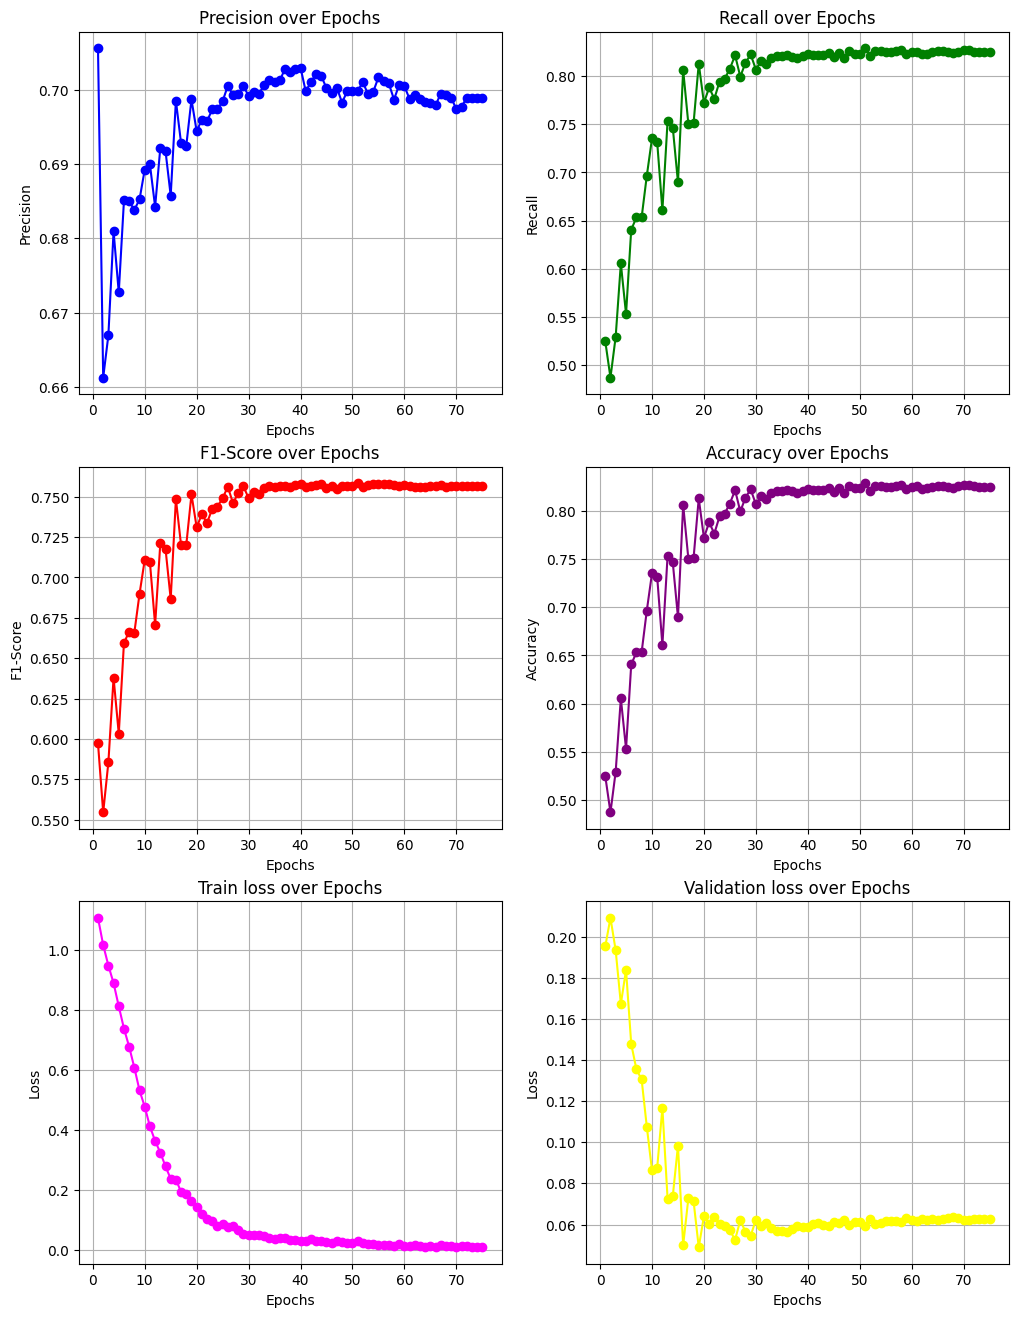

In [77]:
# Plotting the metrics
epochs = range(1, EPOCHS + 1)

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 16))

# Precision plot
axs[0, 0].plot(epochs, precision_scores, marker='o', color='blue')
axs[0, 0].set_title('Precision over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].grid(True)

# Recall plot
axs[0, 1].plot(epochs, recall_scores, marker='o', color='green')
axs[0, 1].set_title('Recall over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].grid(True)

# F1-Score plot
axs[1, 0].plot(epochs, f1_scores, marker='o', color='red')
axs[1, 0].set_title('F1-Score over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('F1-Score')
axs[1, 0].grid(True)

# Accuracy plot
axs[1, 1].plot(epochs, accuracy_scores, marker='o', color='purple')
axs[1, 1].set_title('Accuracy over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].grid(True)

# Train loss plot
axs[2, 0].plot(epochs, train_loss_per_epoch, marker='o', color='magenta')
axs[2, 0].set_title('Train loss over Epochs')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].grid(True)

# Validation loss plot
axs[2, 1].plot(epochs, val_loss_per_epoch, marker='o', color='yellow')
axs[2, 1].set_title('Validation loss over Epochs')
axs[2, 1].set_xlabel('Epochs')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].grid(True)

# Show all plots
plt.show()

# Creating test dataset

In [78]:
test_labels = torch.tensor(test_tokenized['labels'])
test_input_ids = torch.tensor(test_tokenized['input_ids'])
test_attention_masks = torch.tensor(test_tokenized['attention_mask'])

In [79]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
test_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Evaluate

In [80]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
test_pred = []
test_true = []

with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

        logit = output.logits

        test_pred.extend(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))
        test_true.extend(labels.cpu().numpy())

test_pred_flat = np.array(test_pred).flatten()
test_true_flat = np.array(test_true).flatten()

# Calculate evaluation metrics
precision = precision_score(test_true_flat, test_pred_flat, average='weighted', zero_division=0)
recall = recall_score(test_true_flat, test_pred_flat, average='weighted')
f1 = f1_score(test_true_flat, test_pred_flat, average='weighted')
accuracy = accuracy_score(test_true_flat, test_pred_flat)

# Print or use evaluation metrics
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

0it [00:00, ?it/s]

Precision:  0.7706122554391712
Recall:  0.8694164901129944
F1 Score:  0.8151975604188287
Accuracy:  0.8694164901129944


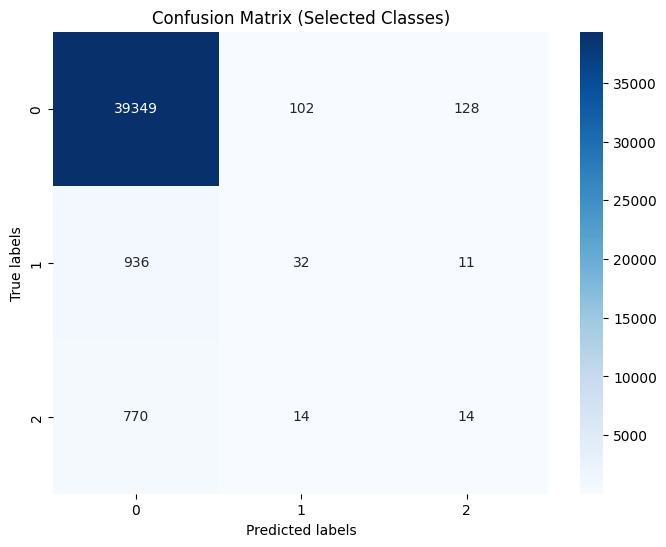

In [81]:
# Compute confusion matrix
conf_matrix = confusion_matrix(test_true_flat, test_pred_flat)

# Mapping actual class labels to display labels
label_mapping = {-100: 0, 0: 1, 1: 2, 2: 3}

# Define the display labels you want to show on the confusion matrix (0, 1, 2)
display_labels = [0, 1, 2]

# Filter and reorganize the confusion matrix based on display labels
filtered_conf_matrix = [[conf_matrix[label_mapping[i]][label_mapping[j]] for j in display_labels] for i in display_labels]

# Plot confusion matrix with selected labels
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Selected Classes)')
plt.show()

# Free RAM

In [ ]:
del precision_scores
del recall_scores
del f1_scores
del accuracy_scores
del model
del scheduler
del optimizer
del train_loss_per_epoch
del val_loss_per_epoch
del class_weight_loss

In [ ]:
torch.cuda.empty_cache()

# Save scores

In [82]:
train_scores = {
    'Metric': ['Precision'] * len(precision_scores) +
              ['Recall'] * len(recall_scores) +
              ['F1'] * len(f1_scores) +
              ['Accuracy'] * len(accuracy_scores) +
              ['Training Loss'] * len(train_loss_per_epoch) +
              ['Validation Loss'] * len(val_loss_per_epoch),

    'Value': precision_scores + recall_scores + f1_scores + accuracy_scores + train_loss_per_epoch + val_loss_per_epoch
}

# Create a DataFrame
train_scores_df = pd.DataFrame(train_scores)

# Save DataFrame to a CSV file
csv_file_path = 'scores_and_losses.csv'
train_scores_df.to_csv(csv_file_path, index=False)

print(f'Scores and losses saved to {csv_file_path}')

Scores and losses saved to scores_and_losses.csv


In [83]:
test_scores = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Value': [precision, recall, f1, accuracy]
}

# Create a DataFrame
test_scores_df = pd.DataFrame(test_scores)

# Save DataFrame to a CSV file
csv_file_path = 'test_results.csv'
test_scores_df.to_csv(csv_file_path, index=False)

print(f'Test scores saved to {csv_file_path}')

Test scores saved to test_results.csv


In [ ]:
del train_scores
del train_scores_df
del test_scores
del test_scores_df

# Read Scores and plot data

In [ ]:
# Path to the CSV file containing the scores and losses
csv_file_path = 'scores_and_losses.csv'

# Read the CSV file into a pandas DataFrame
train_scores_df = pd.read_csv(csv_file_path)

# Separate the metrics into different lists
precision_scores = train_scores_df[train_scores_df['Metric'] == 'Precision']['Value'].tolist()
recall_scores = train_scores_df[train_scores_df['Metric'] == 'Recall']['Value'].tolist()
f1_scores = train_scores_df[train_scores_df['Metric'] == 'F1']['Value'].tolist()
accuracy_scores = train_scores_df[train_scores_df['Metric'] == 'Accuracy']['Value'].tolist()
train_loss_per_epoch = train_scores_df[train_scores_df['Metric'] == 'Training Loss']['Value'].tolist()
val_loss_per_epoch = train_scores_df[train_scores_df['Metric'] == 'Validation Loss']['Value'].tolist()

csv_file_path = 'test_results.csv'
test_scores_df = pd.read_csv(csv_file_path)
precision = float(test_scores_df[test_scores_df['Metric'] == 'Precision']['Value'])
recall = float(test_scores_df[test_scores_df['Metric'] == 'Recall']['Value'])
f1 = float(test_scores_df[test_scores_df['Metric'] == 'F1 Score']['Value'])
accuracy = float(test_scores_df[test_scores_df['Metric'] == 'Accuracy']['Value'])

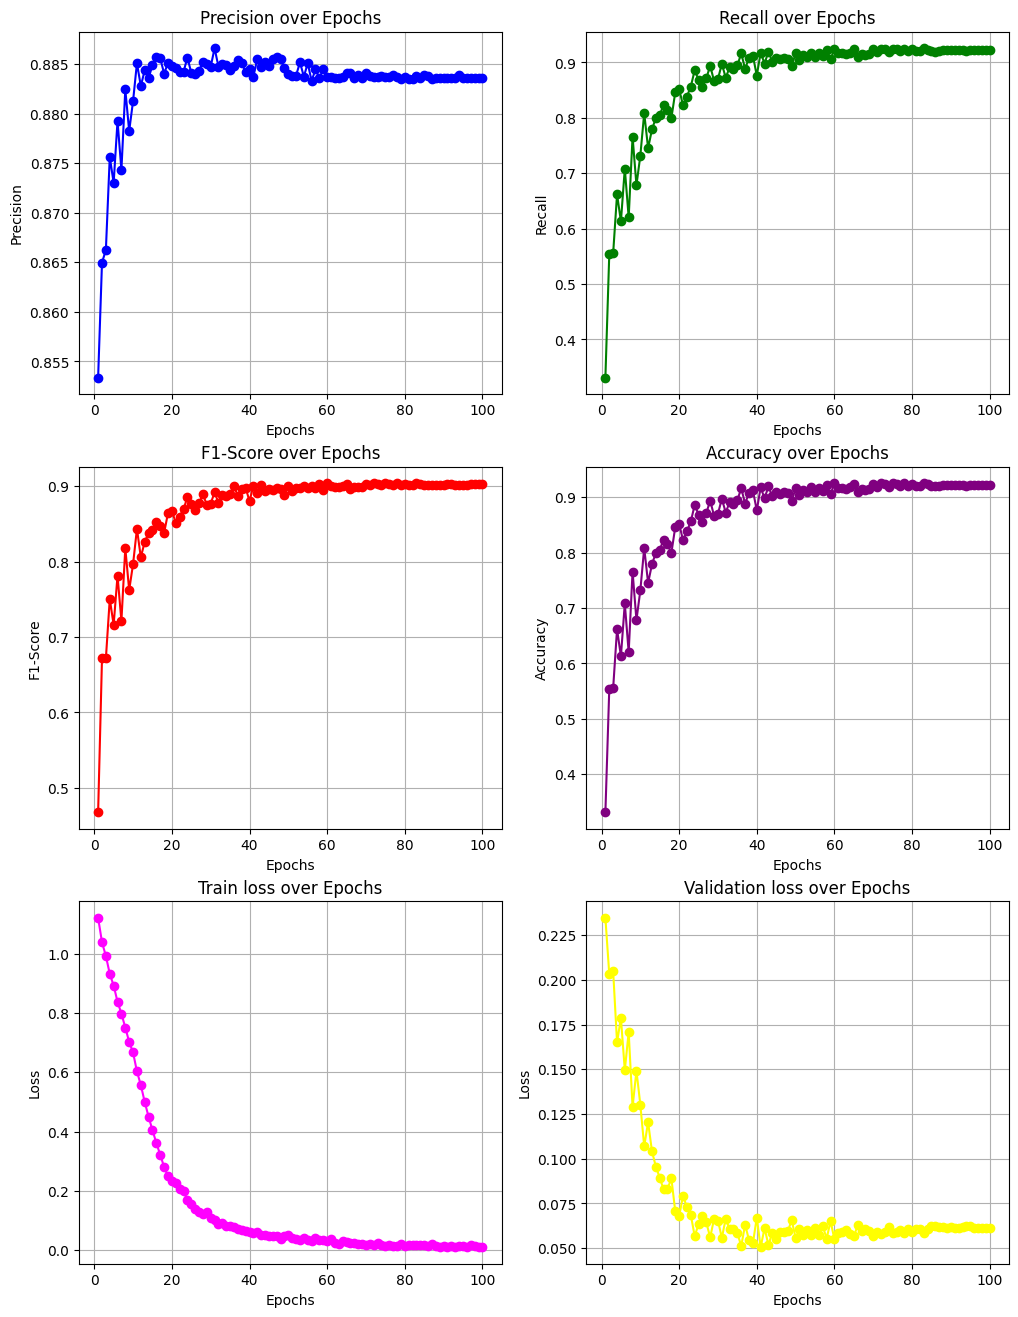

In [ ]:
# Plotting the metrics
epochs = range(1, EPOCHS + 1)

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 16))

# Precision plot
axs[0, 0].plot(epochs, precision_scores, marker='o', color='blue')
axs[0, 0].set_title('Precision over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].grid(True)

# Recall plot
axs[0, 1].plot(epochs, recall_scores, marker='o', color='green')
axs[0, 1].set_title('Recall over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].grid(True)

# F1-Score plot
axs[1, 0].plot(epochs, f1_scores, marker='o', color='red')
axs[1, 0].set_title('F1-Score over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('F1-Score')
axs[1, 0].grid(True)

# Accuracy plot
axs[1, 1].plot(epochs, accuracy_scores, marker='o', color='purple')
axs[1, 1].set_title('Accuracy over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].grid(True)

# Train loss plot
axs[2, 0].plot(epochs, train_loss_per_epoch, marker='o', color='magenta')
axs[2, 0].set_title('Train loss over Epochs')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].grid(True)

# Validation loss plot
axs[2, 1].plot(epochs, val_loss_per_epoch, marker='o', color='yellow')
axs[2, 1].set_title('Validation loss over Epochs')
axs[2, 1].set_xlabel('Epochs')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].grid(True)

# Show all plots
plt.show()

In [ ]:
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.7685820623535459
Recall:  0.8674081920903954
F1 Score:  0.8138002905394909
Accuracy:  0.8674081920903954


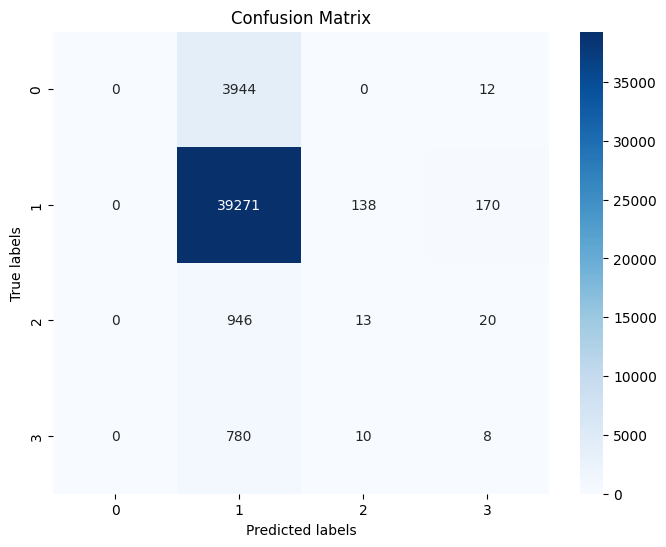

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(test_true_flat, test_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()